LIME_Stratified

### Import Libraries

In [5]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.preprocessing import image
from lime import lime_image
from skimage.segmentation import mark_boundaries
import utils as ut
from lime.wrappers.scikit_image import SegmentationAlgorithm

# Load Blackbox ML Model

In [21]:
# Load the pre-trained model
model = mobilenet_v2.MobileNetV2(weights='imagenet')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


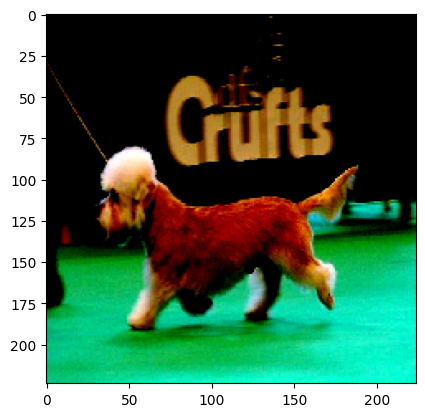

In [22]:
img_path = '../images/ILVRC_2012/ILSVRC2012_test_00000003.JPEG'
# Preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = mobilenet_v2.preprocess_input(img_array)
plt.imshow(img_array[0])
plt.show()

In [24]:
def bb_predict(imgs):
    # On some platform, you will need model.predict(..) instead of model(..)
    return model.predict(mobilenet_v2.preprocess_input(imgs), verbose=False)
#     return model(preprocess_input(imgs))

In [25]:
# Make a prediction
preds = model.predict(img_array)
decoded_preds = tf.keras.applications.imagenet_utils.decode_predictions(preds, top=3)[0]
print("Predictions:", decoded_preds)

Predictions: [('n02096437', 'Dandie_Dinmont', 0.28083292), ('n02091635', 'otterhound', 0.09809891), ('n02113799', 'standard_poodle', 0.03486852)]


In [26]:
def get_segment_number(image, md):
    segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=4, max_dist=md, ratio=0.2, random_seed=1234) 
    segments = segmentation_fn(image)
    return len(np.unique(segments))

def search_segment_number(image, target_seg_no, init_max_dist=100):
    lmd, rmd = 0, init_max_dist
    lsn = get_segment_number(image, lmd)
    rsn = get_segment_number(image, rmd)
    niter = 0
    while niter<40 and rsn!=target_seg_no:
        niter += 1
        mmd = (lmd + rmd) / 2.0
        msn = get_segment_number(image, mmd)
        if msn <= target_seg_no <= lsn:
            rsn, rmd = msn, mmd
        else:
            lsn, lmd = msn, mmd
    return rmd
segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=4, 
                                            max_dist=search_segment_number(img_array[0], 100), 
                                            ratio=0.2, random_seed=1234) 
                                            
segments = segmentation_fn(img_array[0])
def segments_getter(img):
    return segments
num_segments = len(np.unique(segments))

In [27]:
# LIME Image Explanation
explainer = lime_image.LimeImageExplainer()

# Explanation for the top predicted class
explanation = explainer.explain_instance(
    img_array[0].astype('double'),
    bb_predict,
    top_labels=1,
    hide_color=0,
    #segmentation_fn=segments_getter,
    #use_stratification=False,   # Switching from Monte Carlo to Stratification Sampling Strategy
    num_samples=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [28]:
# Get the image explanation for the top label
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    num_features=50,
    hide_rest=True
)

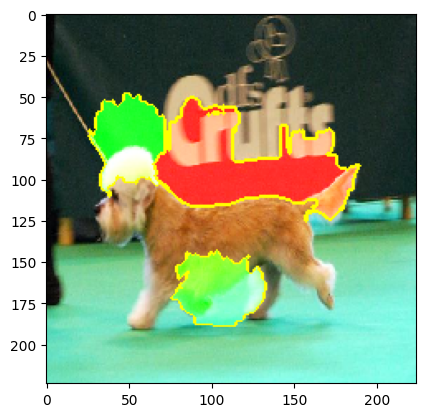

In [32]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))